##### Author: Juste Nyirimana

# Predicting Churn for Bank Customers challenge

In this challenge we are going to predict whether a customer will leave the bank or not using machine learning algorithms.

## Table of Contents:
&nbsp;&nbsp;1. [Exploratory Data Analysis](#1)
   
&nbsp;&nbsp;2. [Preprocessing for Churn Modeling](#2)   

&nbsp;&nbsp;3. [Churn Prediction](#3)   

&nbsp;&nbsp;4. [Model Tuning](#4)

&nbsp;&nbsp;5. [Data Resampling](#5)

&nbsp;&nbsp;6. [Stacking Ensemble Method](#6)

&nbsp;&nbsp;7. [Comments](#7)

&nbsp;&nbsp;8. [Conclusion](#8)

## 1. Exploratory Data Analysis (EDA) <a id="1"></a>

The aim of doing an Exploratory Data Analysis (EDA) is to understand the data we have which in turn will help us to build a good solution.

In [ ]:
# loading necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn import metrics
import missingno as msno
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
import warnings 
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.metrics import f1_score
import scipy as sp
import os
import scikitplot as skplt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# to increase the display capacity
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
df_train = pd.read_csv('../input/predicting-churn-for-bank-customers/Churn_Modelling.csv')

In [ ]:
df_train.head()

In [ ]:
df_train.info()

In [ ]:
df_train.isnull().sum()

Great news!!! There are no missing values.

In [ ]:
print(df_train.Exited.value_counts())
#Visualising non-churners and churners cases
plt.bar("Churn", df_train["Exited"].value_counts()[1], color="red")
plt.bar("No Churn", df_train["Exited"].value_counts()[0], color="green")
plt.ylabel("Count", fontsize=14)
plt.title("Churn VS No Churn")

The data is imbalanced i.e. we have way more non-churners (7963) than churners (2037). This can bias the model's performance.

#### Summary statistics for both classes

In [ ]:
df_train.groupby('Exited')['CreditScore'].mean() 

In [ ]:
df_train.groupby('Exited')['Age'].mean() 

In [ ]:
df_train.groupby('Exited')['Balance'].mean() 

In [ ]:
df_train.groupby('Exited')['EstimatedSalary'].mean() 

In [ ]:
df_train.describe()

A few observations can be made from the table above:
    - They youngest client(s) is 18 years old while the oldest is 92.
    - There are no negative balance in the dataset. The least cash anyone has is 0.
    - The columns 'HasCrCard' and 'IsActiveMember' can only take two possible values, 0 or 1.

In [ ]:
df_train.Tenure.value_counts()

In [ ]:
df_train.NumOfProducts.value_counts()

The most used product is 'product 1' while the least used one is 'product 4'

In [ ]:
df_train.HasCrCard.value_counts()

More than 70% of the clients have/own a credit card.

In [ ]:
df_train.IsActiveMember.value_counts()

In [ ]:
df_train.describe(exclude = 'number')

In [ ]:
df_train.Geography.value_counts()

Half of the clients are from France while the remaining reside in Germany and Spain.

In [ ]:
df_train.Gender.value_counts()

There is no gender gap. It is pretty well balanced.

#### Churn by Country

In [ ]:
df_train.groupby('Geography')['Exited'].value_counts()

There is a problem in germany. Almost half of the clients in Germany end up leaving.

#### Churn by Gender

In [ ]:
df_train.groupby('Gender')['Exited'].value_counts()

There are more women leaving the bank than men.

#### Churn by Product Number

In [ ]:
df_train.groupby('NumOfProducts')['Exited'].value_counts()

All users of product 4 have churned, an indication that it is not a good product!!
Also most users of product 3 end up leaving too.

#### Product Number by Gender

In [ ]:
df_train.groupby('Gender')['NumOfProducts'].value_counts()

Both female and male prefer the same products (1 & 2).

#### Churn by Tenure

In [ ]:
df_train.groupby('Tenure')['Exited'].value_counts()

#### Statistics between Churners and non churners

In [ ]:
def describe(datatrain, feature):
    d = pd.DataFrame(columns=[feature,'Train','Train - Churn','Train - No Churn'])
    d[feature] = ['count','mean','std','min','25%','50%','75%','max','unique','NaN','NaNshare']
    for i in range(0,8):
        d['Train'].iloc[i] = datatrain[feature].describe().iloc[i]
        d['Train - Churn'].iloc[i]=datatrain[datatrain['Exited']==1][feature].describe().iloc[i]
        d['Train - No Churn'].iloc[i]=datatrain[datatrain['Exited']==0][feature].describe().iloc[i]
    d['Train'].iloc[8] = len(datatrain[feature].unique())
    d['Train - Churn'].iloc[8]=len(datatrain[datatrain['Exited']==1][feature].unique())
    d['Train - No Churn'].iloc[8]=len(datatrain[datatrain['Exited']==0][feature].unique())
    d['Train'].iloc[9] = datatrain[feature].isnull().sum()
    d['Train - Churn'].iloc[9] = datatrain[datatrain['Exited']==1][feature].isnull().sum()
    d['Train - No Churn'].iloc[9] = datatrain[datatrain['Exited']==0][feature].isnull().sum()
    d['Train'].iloc[10] = datatrain[feature].isnull().sum()/len(datatrain)
    d['Train - Churn'].iloc[10] = datatrain[datatrain['Exited']==1][feature].isnull().sum()/len(datatrain[datatrain['Exited']==1])
    d['Train - No Churn'].iloc[10] = datatrain[datatrain['Exited']==0][feature].isnull().sum()/len(datatrain[datatrain['Exited']==0])
    return d

In [ ]:
BalanceAmtDescribe = describe(df_train,'Balance')

In [ ]:
BalanceAmtDescribe

In [ ]:
df_train[df_train['Balance']>222000]

The clients with the highest account balances churned. Not good.

In [ ]:
AgeDescribe = describe(df_train,'Age')

In [ ]:
AgeDescribe

In [ ]:
df_train[df_train['Age']>=80]

Senior citizens are less likely to leave but also half of them have 0 in their account.

#### Churn by Age

In [ ]:
train_age = (df_train.groupby(['Exited'])['Age']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Age'))
                     
plt.figure(figsize=(20,20))
sns.barplot(x="Age", y="percentage", hue="Exited", data=train_age)

There is a high risk to churn among middle aged clients (42-65)

#### Exploring feature distributions

In [ ]:
# Visualize the distribution of 'Day_Mins'
sns.distplot(df_train.CreditScore)

# Display the plot
plt.show()

In [ ]:
# Visualize the distribution of 'Day_Mins'
sns.distplot(df_train.Age)

# Display the plot
plt.show()

In [ ]:
# Visualize the distribution of 'Day_Mins'
sns.distplot(df_train.Balance)

# Display the plot
plt.show()

In [ ]:
# Visualize the distribution of 'Day_Mins'
sns.distplot(df_train.EstimatedSalary)

# Display the plot
plt.show()

#### Differences in Balance

In [ ]:
sns.boxplot(x = 'Exited',
           y = 'Balance',
           data = df_train)
plt.show()

There is no difference in balance between the two classes

In [ ]:
sns.boxplot(x = 'Exited',
           y = 'Balance',
           data = df_train,
           hue = 'Geography')
plt.show()

None of the clients in Germany have 0 in their account and they also tend to have more cash in their accounts compared to other clients from the other 2 countries.

In [ ]:
sns.boxplot(x = 'Exited',
           y = 'CreditScore',
           data = df_train)
plt.show()

There is no real difference in credit score between churners and non churners except that all the Clients with a credit score lower than 400 churned.

In [ ]:
# Printing the filtered dataframe to verify to verify
df_train[df_train['CreditScore'] < 400]

In [ ]:
sns.boxplot(x = 'Exited',
           y = 'Age',
           data = df_train)
plt.show()

There seems to be more young clients staying than old clients. Which might be a hint that the bank doesn't offer good retirement plans

In [ ]:
df_train.head()

#### Correlation matrix

In [ ]:
correlations = df_train.corr()
fig = plt.figure(figsize = (9, 6))

sns.heatmap(correlations, vmax = .8, square = True)
plt.show()

In [ ]:
k = 10 #number of variables for heatmap
cols = correlations.nlargest(k, 'Exited')['Exited'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(15, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## 2. Preprocessing for Churn Modeling <a id="2"></a>

#### Dropping unnecessary features

Features such as 'RowNumber', 'CustomerId', 'Surname' are not useful when it comes to predicting customer churn, and they need to be dropped prior to modeling. 

In [ ]:
# Drop the unnecessary features
df_train = df_train.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

#### Encoding binary features

In [ ]:
# Replacing 'Male' with 0 and 'Female' with 1 
df_train['Gender'] = df_train['Gender'].replace({'Male': 0, 'Female': 1})

# Print the results to verify
print(df_train['Gender'].head())

#### One hot encoding the 'Geography', 'Tenure', and 'NumOfProducts' columns since they have more two unique outcome.

In [ ]:
# Perform one hot encoding on 'Geography'
df_train = pd.get_dummies(data=df_train, columns=['Geography', 'Tenure', 'NumOfProducts'])

## 3. Churn Prediction <a id="3"></a>

#### Creating training and test sets

We split the dataset into two: a training set which will be used to build the churn model, and a test set which will be used to validate the model. Since the distribution of the target variable is uneven, we will use the parameter 'stratify' which will take into account the distribution of the classes ('Churn' or 'No churn').

In [ ]:
# Create feature variables
X = df_train.drop('Exited', axis=1)

# Create target variable
y = df_train['Exited']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)

We are going to try out different algorithms and pick the one with the best performance. To measure a model's performance, we will use the Area Under the Curve of the test set. We will also use the confusion matrix to gain a more nuanced understanding of its performance

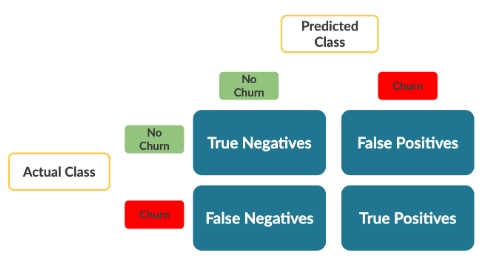

Moreover, we will look at the precision and recall of the best performing models to decide which model to use depending on the bank's needs.

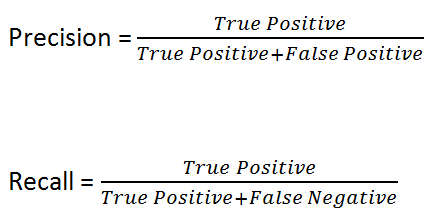

The first model we'll look at is:

#### Random Forest

In [ ]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
clf = RandomForestClassifier(class_weight='balanced_subsample', random_state=123)

# Fit to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Compute accuracy
#print(clf.score(X_test, y_test))

# Generate the probabilities
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Print the AUC
print(roc_auc_score(y_test, y_pred_prob))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

##### XGBoost

In [ ]:
from xgboost import XGBClassifier
# Instantiate the classifier
clf = XGBClassifier(random_state=123)

# Fit to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Generate the probabilities
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Print the AUC
print(roc_auc_score(y_test, y_pred_prob))

skplt.metrics.plot_confusion_matrix(y_test, y_pred)

##### lightgbm

In [ ]:
from lightgbm import LGBMClassifier
# Instantiate the classifier
clf = LGBMClassifier(random_state=123)

# Fit to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Generate the probabilities
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Print the AUC
print(roc_auc_score(y_test, y_pred_prob))

skplt.metrics.plot_confusion_matrix(y_test, y_pred)

##### CatBoost

In [ ]:
from catboost import CatBoostClassifier
# Instantiate the classifier
clf = CatBoostClassifier(random_state=123, logging_level='Silent')

# Fit to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Generate the probabilities
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Print the AUC
print(roc_auc_score(y_test, y_pred_prob))

skplt.metrics.plot_confusion_matrix(y_test, y_pred)

## 4. Model Tuning <a id="4"></a>

The best model is the **classifier** with an auc score of 0.87. To improve the model, I used a grid search cross-validation to identify the hyperparameters that lead to optimal model performance.

In [ ]:
clf = CatBoostClassifier()
params = {'iterations': [500],
          'depth': [4, 5, 6, 7],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'eval_metric': ['AUC'],
#           'use_best_model': ['True'],
          'logging_level':['Silent'],
          'random_seed': [42]
         }
#scorer = make_scorer(accuracy_score)
clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=5)

In [ ]:
clf_grid.fit(X_train, y_train)
best_param = clf_grid.best_params_
best_param

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_pred = clf_grid.predict(X_test)

# Generate the probabilities
y_pred_prob = clf_grid.predict_proba(X_test)[:, 1]

# Print the AUC
print(roc_auc_score(y_test, y_pred_prob))

# Generate the probabilities
y_pred_prob = clf_grid.predict_proba(X_test)[:, 1]

# Print the AUC
print('The AUC score using GridSearchCV is :\n', roc_auc_score(y_test, y_pred_prob))

# Obtain the results from the classification report and confusion matrix 
print(skplt.metrics.plot_confusion_matrix(y_test, y_pred))
target_names = ['No Churn', 'Churn']
print(classification_report(y_test, y_pred, target_names=target_names))

After using GridSearchCV, there is a small improvement.

## Data Resampling <a id="5"></a>

I used another approach called resampling. The aim of resampling is to have a perfect balance between churners and non-churners. There are different [techniques](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets) used to resample an imbalanced dataset. In this case I used and oversampling technique called the **Synthetic Minority Oversampling Technique** (SMOTE). SMOTE uses characteristics of the nearest neighbors of the churn cases (the minority class) to create new synthetic churn cases.

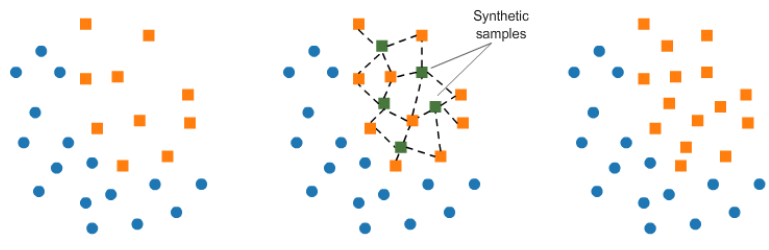

It is also important to note that each resampling technique has its own drawbacks.

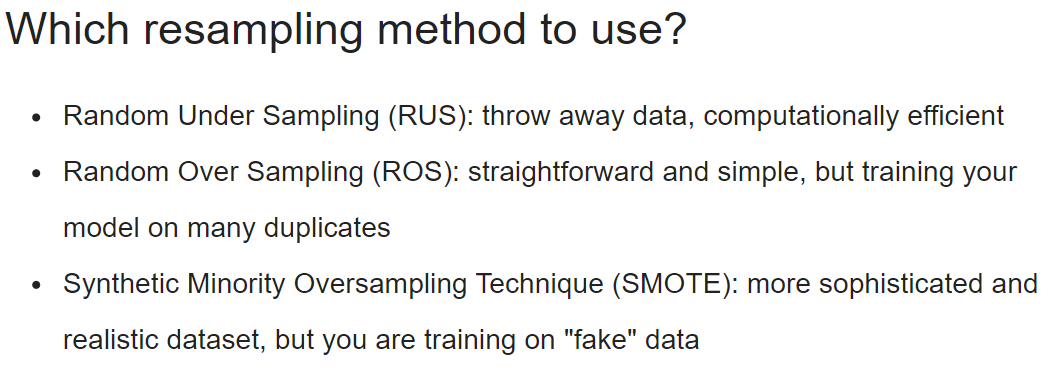

In [ ]:
# This is the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE()
model = CatBoostClassifier(logging_level = 'Silent')

# Define the pipeline, tell it to combine SMOTE with the CatBoost model
pipeline = Pipeline([('SMOTE', resampling), ('CatBoost ', model)])

In [ ]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

# Generate the probabilities
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Print the AUC
print('The AUC score using SMOTE is :\n', roc_auc_score(y_test, y_pred_prob))

# Obtain the results from the classification report and confusion matrix 
conf_mat = skplt.metrics.plot_confusion_matrix(y_test, predicted)
print('Confusion matrix:\n', conf_mat)
print(classification_report(y_test, predicted, target_names=target_names))

## Stacking Ensemble Method (SEM) <a id="6"></a>

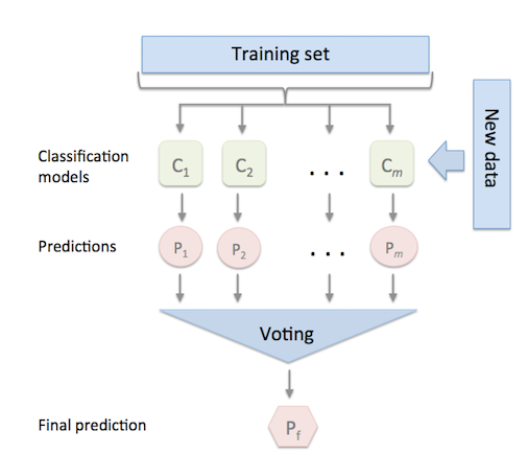

The last method I used is the stacking ensemble method. The SEM is implemented by combining multiple models via a 'voting' rule on the model outcome. The base level models are each trained based on the training set. More often than not, this method produces more accurate predictions than a single model would. 

To implement the ensemble, I used the **voting** classifier. 

In [ ]:
# Import the package
from sklearn.ensemble import VotingClassifier

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

In [ ]:
#fitting the ensemble model onto the training set
ensemble_model.fit(X_train, y_train)

#making predictions
y_pred = ensemble_model.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
conf_mat = skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', conf_mat)
print(classification_report(y_test, y_pred, target_names=target_names))

## Comments <a id="7"></a>

The following are the few observations and comments I made during this analysis:
1. Most users of product 1 and 2 end up churning. This is a sign that something is wrong with them. In cases like this, a market research would be helpful in finding out what is wrong with the two products which can lead to an implementation of better products that customers would enjoy and end up not churning/leaving the bank.

2. The churn rate among women is high. A possible explanation to this is that there is a mismatch between the financial products and services offered by the bank and the needs of women clients.

## Conclusion <a id="8"></a>

Three different techniques were used when fitting the models. The first method consisted of fitting different algorithms, picking the best performing one, and then using GridSearchCV to tune the hyperparameters of that model. The second method used the Synthetic Minority Oversampling Technique to balance the dataset. Lastly, we used the stacking ensemble method which combines a set of models.

To decide which model is appropriate mainly depends on what the bank wants. If they mostly care about finding churners, and not so much about the false positives, then the ensemble method would work best. But if the goal is to find non-churners, then the other two models would be appropriate.

Lastly, the first two models did well in capturing non-churners. They had very few false positives but they didn't do well in capturing churners. This can be caused by the lack of clear indicators of churners. A way to improve the models would be to include more features like the number of customer service calls the customer made, marital status, employment status, etc.